In [19]:
import pathlib

import numpy as np
from copy import deepcopy

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from data.simulated.simulate import shuffle_split, group_sizes, node_feature_distribution, node_community_to_onehot, sample_adjacency, node_community_assignment, sample_edge_weights, sample_node_features
from src.plot import plot_dynamic_graph

import matplotlib.pyplot as plt

In [25]:
num_samples = 1000
num_nodes = 100
num_features = 3
time_len = 10

num_classes = 2

self_loops = False

num_communities = 4
community_sizes = None
intra_edge_prob = [0.01, 0.01] 
inter_edge_prob = [[0.5, 0.8, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8]]
intra_weight_dist = dict(loc=0.2, scale=0.01)
inter_weight_dist = [[dict(loc=0.7, scale=0.01), dict(loc=0.8, scale=0.01), dict(loc=0.9, scale=0.01), dict(loc=1.0, scale=0.01)],
                     [dict(loc=0.7, scale=0.01), dict(loc=0.8, scale=0.01), dict(loc=0.9, scale=0.01), dict(loc=0.8, scale=0.01)]]

################################################

migrate_from_community = [0, 0]
migrate_to_community = [3, 3]
migration_time_frame = [5, 9]

################################################

data_dir = pathlib.Path("../data")
data_dir.mkdir(exist_ok=True)

################################################

class_sizes = group_sizes(num_samples, num_classes)

if community_sizes is None:
    community_sizes = group_sizes(num_nodes, num_communities)

node_feature_mean, node_feature_var = node_feature_distribution(num_features, num_communities)

sample_counter = 0

samples_adjacency_ts = []
samples_node_community_ts = []
samples_node_features_ts = []
samples_label = []

for label in range(num_classes):

    # initialze community edge probability matrix
    community_edge_probability = np.ones((num_communities, num_communities)) * intra_edge_prob[label] 
    np.fill_diagonal(community_edge_probability, inter_edge_prob[label])
            
    for _ in range(class_sizes[label]):

        # initialze mask to keep track on node migrations
        mask = np.ones((num_nodes, num_nodes))

        # initialize node community assignment
        node_community = node_community_assignment(community_sizes)

        
        node_community_one_hot = node_community_to_onehot(node_community)
        prob_edge = (node_community_one_hot @ community_edge_probability) @ node_community_one_hot.T
        
        # sample initial adjaceny
        adjacency = sample_adjacency(prob_edge, self_loops=self_loops)
        # sample initial edge weights
        edge_weights = sample_edge_weights(node_community, intra_weight_dist, inter_weight_dist[label])
        # sample initial node features
        node_features = sample_node_features(node_community_one_hot, node_feature_mean, node_feature_var)

        # append initial samples to timeseries
        adjacency_ts = [adjacency * edge_weights]
        node_community_ts = [node_community_one_hot]
        node_features_ts = [node_features]

        # nodes to migrate split over specified timeframe
        nodes_migrate_ts = shuffle_split(node_community[migrate_from_community[label]], migration_time_frame[label])

        for time, nodes in enumerate(nodes_migrate_ts):
            
            node_community = deepcopy(node_community)

            # nodes from community to migrate from
            community_from = migrate_from_community[label]
            nodes_from = node_community[community_from]

            # nodes from community to migrate to
            community_to = migrate_to_community[label]
            nodes_to = node_community[community_to]

            # nodes left in community after migration
            nodes_from = list(set(nodes_from) - set(nodes)) 
            nodes_from.sort()
            node_community[community_from] = nodes_from

            # nodes added to community after migration
            nodes_to = nodes_to + nodes
            nodes_to.sort()
            node_community[community_to] = nodes_to

            for n in nodes:
                indices = [(n, m) for m in range(n + 1)]

                for idxs in indices:
                    mask[idxs[0], idxs[1]] = 0
                    mask[idxs[1], idxs[0]] = 0

            node_community_one_hot = node_community_to_onehot(node_community)
            prob_edge = (node_community_one_hot @ community_edge_probability) @ node_community_one_hot.T
            prob_edge *= mask
            prob_edge += (1 - mask) * community_edge_probability[community_from, community_to]
            
            # sample adjacency
            adjacency = sample_adjacency(prob_edge, self_loops=self_loops)
            # sample node features
            node_features = sample_node_features(node_community_one_hot, node_feature_mean, node_feature_var)
            # sample edge weights
            edge_weights = sample_edge_weights(node_community, intra_weight_dist, inter_weight_dist[label])

            # append samples to timeseries
            adjacency_ts += [adjacency * edge_weights]
            node_community_ts += [node_community_one_hot]
            node_features_ts += [node_features]

        while len(adjacency_ts) < time_len:

            # sample adjacency
            adjacency = sample_adjacency(prob_edge, self_loops=self_loops) 
            # sample node features
            edge_weight = sample_edge_weights(node_community, intra_weight_dist, inter_weight_dist[label])
            # sample edge weights
            node_features = sample_node_features(node_community_one_hot, node_feature_mean, node_feature_var)

            # append samples to timeseries
            adjacency_ts += [adjacency * edge_weight]
            node_community_ts += [node_community_one_hot]
            node_features_ts += [node_features]

        # append sample
        samples_adjacency_ts += [adjacency_ts]
        samples_node_community_ts += [node_community_ts]
        samples_node_features_ts += [node_features_ts]
        samples_label += [label]

        sample_counter += 1

A = np.array(samples_adjacency_ts)
F = np.array(samples_node_community_ts)
X = np.array(samples_node_features_ts)
y = np.array(samples_label)

# np.savez_compressed(data_dir / "data", A=A, X=X, F=F, y=y)

In [26]:
nodes, communities = node_community_one_hot.nonzero()

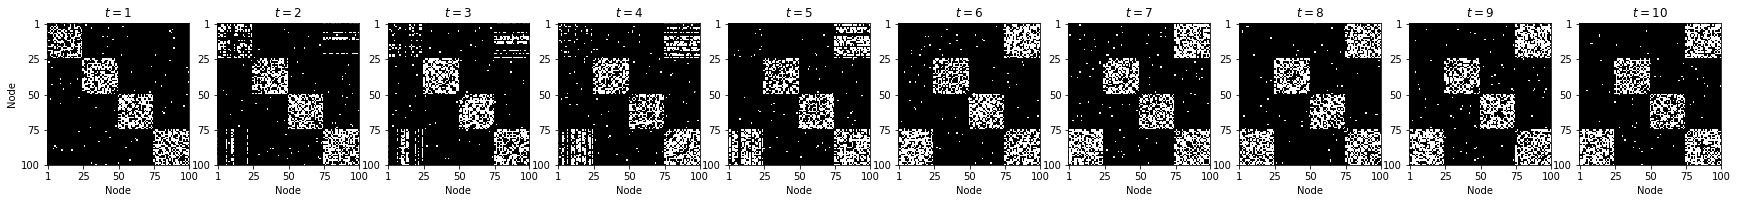

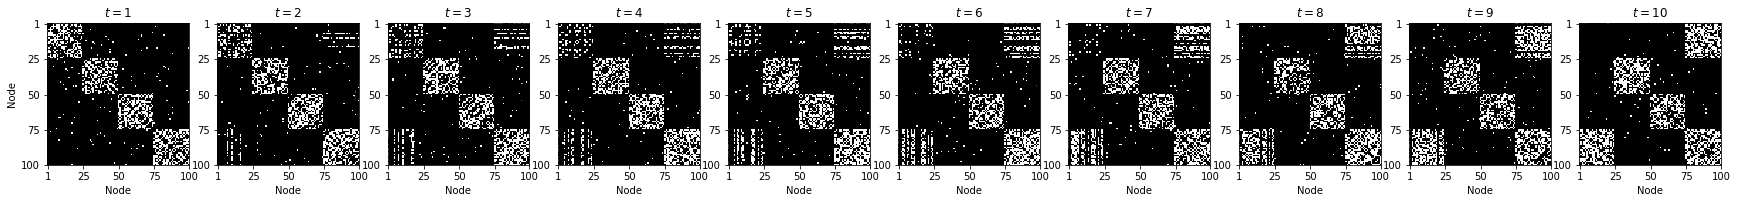

In [27]:
plot_dynamic_graph(np.where(A[0] > 0, 1, 0))
plot_dynamic_graph(np.where(A[-1] > 0, 1, 0))

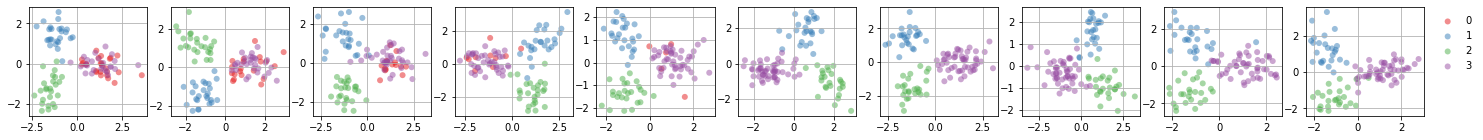

In [28]:
fig, axes = plt.subplots(1, time_len, figsize=(25, 2))

cm = plt.cm.Set1(range(num_communities))

for ax, t in zip(axes.ravel(), range(time_len)):


    Z = PCA(n_components=2).fit_transform(X[0, t, ...]).T
    _C = F[0, t, ...].argmax(-1)

    for _c in range(num_communities):

        ax.scatter(Z[0][_C == _c], Z[1][_C == _c], label=_c, color=cm[_c], alpha=0.5, edgecolors="none")
        ax.grid(True)
        # ax.set_xticks([]); ax.set_yticks([])

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)

plt.show()

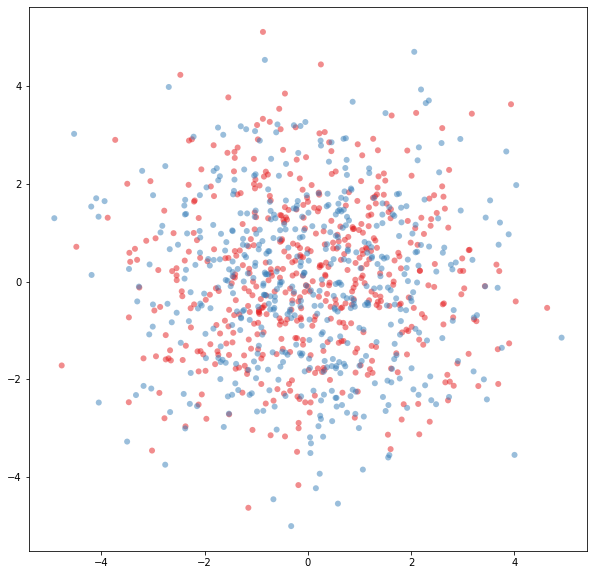

In [29]:
_Z  = PCA(n_components=2).fit_transform(X.reshape(num_samples, -1)).T

fig, ax = plt.subplots(figsize=(10, 10))
for _y in np.unique(y):
    ax.scatter(_Z[0][y == _y], _Z[1][y == _y], label=_y, color=cm[_y], alpha=0.5, edgecolors="none")